In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import models, layers, optimizers, regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
print(tf.config.list_physical_devices('GPU'))

In [5]:
train_path = "/mnt/c/LungCancerCT/CTscans"
data_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.15,
      fill_mode='nearest')

train_generator = data_generator.flow_from_directory(train_path,
                                                    class_mode="binary",
                                                    subset="training",)
validation_generator = data_generator.flow_from_directory(train_path,
                                                    class_mode="binary",
                                                    subset="validation",)
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

Found 748 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [6]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5), #read online works better with set rate than adam
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])


Epoch 1/25


2024-07-31 13:21:21.800792: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-31 13:21:27.655289: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd29c4c1860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-31 13:21:27.655350: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-07-31 13:21:27.663201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722446487.711851   60537 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 34s 999ms/step - loss: 1.1245 - accuracy: 0.7968 - val_loss: 0.8067 - val_accuracy: 0.8538
Epoch 2/25
24/24 [==============================] - 18s 741ms/step - loss: 0.7727 - accuracy: 0.8944 - val_loss: 0.7252 - val_accuracy: 0.9077
Epoch 3/25
24/24 [==============================] - 18s 739ms/step - loss: 0.7002 - accuracy: 0.9251 - val_loss: 0.7132 - val_accuracy: 0.9231
Epoch 4/25
24/24 [==============================] - 18s 729ms/step - loss: 0.7190 - accuracy: 0.9091 - val_loss: 0.6782 - val_accuracy: 0.9308
Epoch 5/25
24/24 [==============================] - 18s 762ms/step - loss: 0.6705 - accuracy: 0.9318 - val_loss: 0.7857 - val_accuracy: 0.9231
Epoch 6/25
24/24 [==============================] - 19s 774ms/step - loss: 0.6626 - accuracy: 0.9398 - val_loss: 0.7652 - val_accuracy: 0.9000
Epoch 7/25
24/24 [==============================] - 19s 778ms/step - loss: 0.6372 - accuracy: 0.9465 - val_loss: 0.6388 - val_accuracy: 0.9462
Epoch 8/25

In [9]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed9':
        set_trainable = True
        continue
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

new_history = model.fit(train_generator,
                    epochs=50, #Maybe less epochs for this one? A lot of layers for a little data
                    validation_data=validation_generator,
                    callbacks=[early_stopping])


Epoch 1/50
24/24 [==============================] - 27s 816ms/step - loss: 0.5701 - accuracy: 0.9652 - val_loss: 0.6478 - val_accuracy: 0.9231
Epoch 2/50
24/24 [==============================] - 18s 745ms/step - loss: 0.5585 - accuracy: 0.9626 - val_loss: 0.6834 - val_accuracy: 0.9308
Epoch 3/50
24/24 [==============================] - 18s 760ms/step - loss: 0.5233 - accuracy: 0.9813 - val_loss: 0.6329 - val_accuracy: 0.9462
Epoch 4/50
24/24 [==============================] - 18s 755ms/step - loss: 0.5226 - accuracy: 0.9813 - val_loss: 0.6180 - val_accuracy: 0.9538
Epoch 5/50
24/24 [==============================] - 18s 736ms/step - loss: 0.5390 - accuracy: 0.9773 - val_loss: 0.6303 - val_accuracy: 0.9462
Epoch 6/50
24/24 [==============================] - 19s 776ms/step - loss: 0.5256 - accuracy: 0.9746 - val_loss: 0.6365 - val_accuracy: 0.9385
Epoch 7/50
24/24 [==============================] - 18s 760ms/step - loss: 0.5198 - accuracy: 0.9826 - val_loss: 0.6811 - val_accuracy: 0.9538

In [12]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)
accuracy_difference = average_train_accuracy - average_val_accuracy

average_train_loss = sum(train_loss) / len(train_loss)
average_val_loss = sum(val_loss) / len(val_loss)

print(f"Average Training Accuracy: {average_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Difference: {accuracy_difference:.4f}")

print(f"Average Training loss: {average_train_loss:.4f}")
print(f"Average Validation loss: {average_val_loss:.4f}")

Average Training Accuracy: 0.9663
Average Validation Accuracy: 0.9311
Difference: 0.0352
Average Training loss: 0.5678
Average Validation loss: 0.6679


In [11]:
history.history['accuracy'].extend(new_history.history['accuracy'])
history.history['val_accuracy'].extend(new_history.history['val_accuracy'])
history.history['loss'].extend(new_history.history['loss'])
history.history['val_loss'].extend(new_history.history['val_loss'])

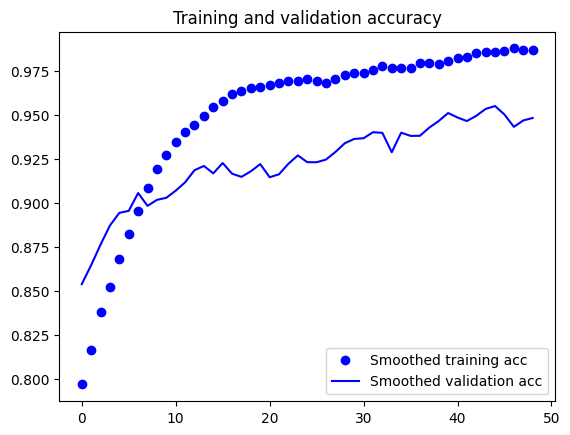

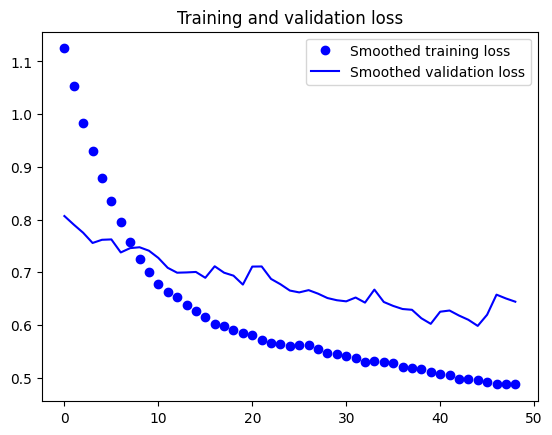

In [13]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
test_path = "/mnt/c/LungCancerCT/final_test_images"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(256, 256),
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

model.save('InceptionV3.keras')

Found 99 images belonging to 2 classes.
4/4 [==============================] - 4s 1s/step - loss: 0.4964 - accuracy: 0.9899
test acc: 0.9898989796638489
